# Calculate Arctic Regional atmospheric momentum flux from CESM2-LE

* **Description**: Reads in and creates regional integrated values from CESM2-LE
* **Input data**: CESM2-LE data, read using intake-esm
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster


Spin up dask cluster

In [2]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37027 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/37027/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/37027/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:45517,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/37027/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [4]:
# list the variables to load
var_in_1 = 'SHFLX'
var_in_2 = 'LHFLX'

In [5]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
#cat

In [7]:
forcing = 'cmip6'  # do not want smbb data
comp = 'atm'
freq = 'month_1'
exp = 'ssp370'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, component=comp, frequency=freq, experiment=exp )
subset_2 = cat.search(variable=var_in_2, forcing_variant=forcing, component=comp, frequency=freq, experiment=exp )

In [8]:
subset_1

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [9]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.forcing_variant.unique())
print(member_id)

['cmip6']


In [10]:
subset_1.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SHFLX,2015-01,2024-12,201501-202412,Surface sensible heat flux,W/m2,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SHFLX,2025-01,2034-12,202501-203412,Surface sensible heat flux,W/m2,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SHFLX,2035-01,2044-12,203501-204412,Surface sensible heat flux,W/m2,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SHFLX,2045-01,2054-12,204501-205412,Surface sensible heat flux,W/m2,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,SHFLX,2055-01,2064-12,205501-206412,Surface sensible heat flux,W/m2,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [11]:
client

<Client: 'tcp://10.12.206.54:45517' processes=32 threads=64, memory=800.00 GiB>

In [12]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})
    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_2 = subset_2.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 15.5 s, sys: 628 ms, total: 16.2 s
Wall time: 26.5 s


In [13]:
# print names of the dataset keys. 
dsets_1.keys()

dict_keys(['atm.ssp370.cam.h0.cmip6.SHFLX'])

In [14]:
# load in the historical and future datasets
futures_1 = []
futures_2 = []

for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)
    
for key in sorted(dsets_2.keys()):
    futures_2.append(dsets_2[key])
    print(key)

atm.ssp370.cam.h0.cmip6.SHFLX
atm.ssp370.cam.h0.cmip6.LHFLX


In [15]:
# Note, this is 14 but several of the ensembles have multiple member_ids because they are the micro
len(futures_2)

1

In [16]:
# Now put these into an array
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    future_1_ds = xr.concat(futures_1, dim='member_id', data_vars="minimal", coords="minimal", compat="override")

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    future_2_ds = xr.concat(futures_2, dim='member_id', data_vars="minimal", coords="minimal", compat="override")


In [17]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_all_1 = future_1_ds
ds_all_2 = future_2_ds

In [18]:
ds_all_1

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33, time: 1032, member_id: 50)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    SHFLX         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.0
    host:                    mom1
    intake_esm_varname:      ['SHFLX']
    logname:                 sunseon
    time_period_freq:        month_1
    source:                  CAM
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  atm.ssp370.cam.h0.cmip6.SHFLX

In [19]:
ds_all_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [20]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all_1.time_bnds.load().mean(dim='nbnd')

<xarray.DataArray 'time_bnds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [21]:
ds_all_1['time'] = ds_all_1.time_bnds.load().mean(dim='nbnd')
ds_all_2['time'] = ds_all_2.time_bnds.load().mean(dim='nbnd')

In [22]:
ds_all_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [23]:
var_1 = ds_all_1[var_in_1]
var_2 = ds_all_2[var_in_2]

In [24]:
# calculate total turbulent surface flux from both inputs
var = var_1 + var_2

## Mask Arctic Ocean only

In [25]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [26]:
my_mask = ds_masks['atm_ArcOc_mask']

In [27]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

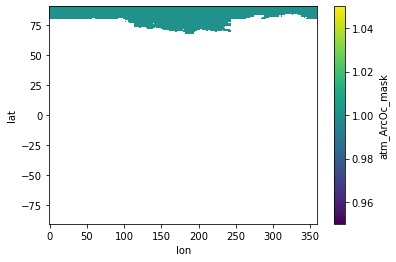

In [28]:
my_mask.plot()

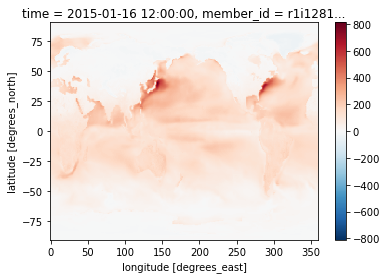

In [29]:
# check data
var.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [30]:
#mask just NH cap
var_masked = var.where(my_mask==1)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


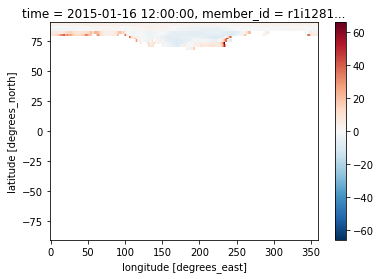

In [31]:
#just test that it worked properly
var_masked.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [32]:
#just test that it worked properly
var_masked.sel(member_id='r1i1281p1f1').isel(time=0).values

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.06949377, -0.11288941, -0.24339086, ..., -0.4681545 ,
        -0.23083907, -0.08555961],
       [ 3.058408  ,  3.0623302 ,  3.0650702 , ...,  3.0667608 ,
         3.0574899 ,  3.0562649 ],
       [ 3.9415956 ,  3.939465  ,  3.9375222 , ...,  3.949379  ,
         3.9465225 ,  3.943939  ]], dtype=float32)

## Calculate regional averages

Just average over everything we have not masked out

In [33]:
avg = var_masked.mean(dim=['lat','lon'])

In [34]:
# set some values for the data
longname = 'Total turbulent surface heat flux'
units = var_1.units

In [35]:
units

'W/m2'

### Actually load the data now

Before, all the calculations were "lazy" version

In [36]:
%%time
## slow step
avg.load()

CPU times: user 3.67 s, sys: 127 ms, total: 3.8 s
Wall time: 7.35 s


<xarray.DataArray (member_id: 50, time: 1032)>
array([[ 0.12357505,  3.5240107 ,  3.0149083 , ..., 12.28757   ,
        27.360695  , 45.49935   ],
       [ 3.4631112 ,  2.3757267 ,  2.5126617 , ..., 18.053265  ,
        37.147747  , 29.55841   ],
       [ 4.5041037 ,  1.6184839 ,  1.1326516 , ..., 23.239246  ,
        29.320194  , 37.972973  ],
       ...,
       [ 3.275738  ,  0.58180946,  0.6353134 , ..., 23.977882  ,
        34.380867  , 37.871464  ],
       [ 0.7226857 ,  1.4152828 , -0.5893777 , ..., 21.210169  ,
        37.755703  , 38.68824   ],
       [ 1.5035536 , -2.864905  ,  6.618916  , ..., 23.301512  ,
        28.426126  , 43.511738  ]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [37]:
avg.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [38]:
avg

<xarray.DataArray (member_id: 50, time: 1032)>
array([[ 0.12357505,  3.5240107 ,  3.0149083 , ..., 12.28757   ,
        27.360695  , 45.49935   ],
       [ 3.4631112 ,  2.3757267 ,  2.5126617 , ..., 18.053265  ,
        37.147747  , 29.55841   ],
       [ 4.5041037 ,  1.6184839 ,  1.1326516 , ..., 23.239246  ,
        29.320194  , 37.972973  ],
       ...,
       [ 3.275738  ,  0.58180946,  0.6353134 , ..., 23.977882  ,
        34.380867  , 37.871464  ],
       [ 0.7226857 ,  1.4152828 , -0.5893777 , ..., 21.210169  ,
        37.755703  , 38.68824   ],
       [ 1.5035536 , -2.864905  ,  6.618916  , ..., 23.301512  ,
        28.426126  , 43.511738  ]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

### Plot just to check

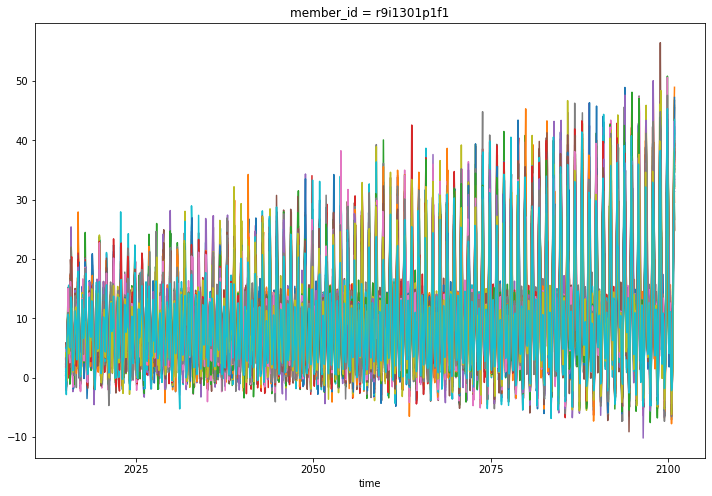

In [39]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in avg.member_id.values:
    avg.sel(member_id=member_id).plot(ax=ax, label=member_id)

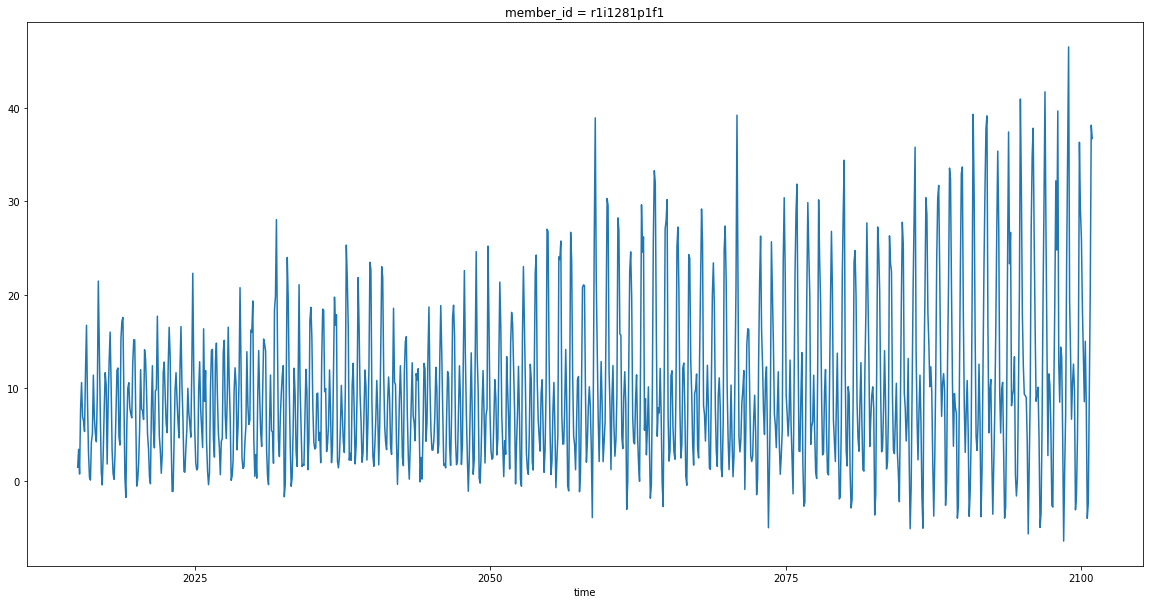

In [40]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
avg.sel(member_id='r1i1281p1f1').plot(ax=ax, label='r1i1281p1f1')

### Save the timeseries

In [41]:
fout = 'CESM2-LE_all_transient_regional_avg_TURBFLX'

In [42]:
ds_to_save = xr.Dataset({'regional_avg': (['member_id','time'], avg.data)},
                        coords={'time':(['time'],avg.time.values),
                                'member_id':(['member_id'],avg.member_id.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [43]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:       (member_id: 50, time: 1032)
Coordinates:
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Data variables:
    regional_avg  (member_id, time) float32 0.1236 3.524 3.015 ... 28.43 43.51
Attributes:
    Author:    Alice DuVivier
    units:     W/m2
    longname:  Total turbulent surface heat flux

In [44]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file